### Итоговый проект, вариант 2

Входные данные:
- **[groups.csv](https://disk.yandex.ru/d/58Us0DWOzuWAjg)** - информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа);
- **[groups_add.csv](https://disk.yandex.ru/d/3aARY-P9pfaksg)** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных;
- **[active_studs.csv](https://disk.yandex.ru/d/prbgU-rZpiXVYg)**  - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента;
- **[checks.csv ](https://disk.yandex.ru/d/84hTmELphW2sqQ)** - файл с информацией об оплатах пользователей в дни проведения эксперимента.

Загружаем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import StratifiedTable

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import pandahouse as ph

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.hist(pd_boot_data[0], bins = 50)
    
    

    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    
    
    plt.show()
       
    return {'boot_data': boot_data, 
            'ci': ci, 
            'p_value': p_value}

Считываем файлы и проверяем датафреймы, их размер и типы данных:

In [3]:
groups       = pd.read_csv('Проект_2_groups.csv', sep=';')
groups_add   = pd.read_csv('Проект_2_group_add.csv')
active_studs = pd.read_csv('Проект_2_active_studs.csv', sep=';')
checks       = pd.read_csv('Проект_2_checks.csv', sep=';')

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.shape

(74484, 2)

In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [8]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.shape

(92, 2)

In [10]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [11]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
active_studs.shape

(8341, 1)

In [14]:
active_studs.dtypes

student_id    int64
dtype: object

In [15]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [16]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
checks.shape

(541, 2)

In [18]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [19]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [20]:
checks.student_id.nunique()

541

Каждый из покупателей в датафрейме `checks` совершил только одну покупку, будем иметь это в виду.

### Задание 1. Python
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Для начала объединим датафреймы `groups` и `groups_add` и проведём эксплораторный анализ данных.

In [21]:
full_groups = groups.append(groups_add)
full_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [22]:
full_groups.shape

(74576, 2)

In [23]:
count_control = full_groups[full_groups.grp == 'A'].count()[0]
count_test = full_groups[full_groups.grp == 'B'].count()[0]
total_count = full_groups.shape[0]

print('Участников в контрольной группе - {}. \nУчастников в тестовой группе - {}.\nОбщее количество участников - {}.' \
      .format(count_control, count_test, total_count))

Участников в контрольной группе - 14693. 
Участников в тестовой группе - 59883.
Общее количество участников - 74576.


Заодно посмотрим, все ли айдишники уникальные, не затесались ли случайно повторы и не попал ли один и тот же айдишник в обе группы.

In [24]:
unique_test = full_groups[full_groups.grp == 'B'].id.nunique()
unique_control = full_groups[full_groups.grp == 'A'].id.nunique()

In [25]:
if unique_test == count_test and unique_control == count_control and (unique_test + unique_control == total_count):
    print('OK! Все айдишники уникальные.')
else:
    print('ERROR! Есть повторы!')

OK! Все айдишники уникальные.


Достаточно странно, что в тестовой группе участников в несколько раз больше, чем в контрольной. Обычно бывает наоборот. За неимением дополнительной информации об эксперименте, пока делать какие-то выводы нельзя, но при выборе теста это нужно иметь в виду.

Переименуем колонки:

In [26]:
active_studs = active_studs.rename(columns={'student_id':'id'})
checks = checks.rename(columns={'student_id':'id'})

Добавим колонку `is_active`, чтобы в дальнейшем сделать мёрдж.

In [27]:
active_studs['is_active'] = True

Смёрджим `grops`, `active_studs` и `checks` левым джойном, а затем заменим пропуски в `is_active` на `False`, а в `rev` на `0.0`.

In [28]:
ab_testing = full_groups.merge(active_studs, how='left', on='id') \
                        .merge(checks, how='left', on='id')


ab_testing['is_active'] = ab_testing['is_active'].fillna(False)
ab_testing['rev'] = ab_testing['rev'].fillna(0)

Для самопроверки посмотрим количество строк в результирующем датафрейме, должно остаться столько же, сколько и было в первоначальном.

In [29]:
total_ab = ab_testing.id.nunique()
print('Всего в таблице {} уникальных айдишников.'.format(total_ab))

Всего в таблице 74576 уникальных айдишников.


Теперь проверим, есть ли среди пользователей те, кто был неактивен, но совершил покупку:

In [30]:
ab_testing.query("is_active == '0' and rev > 0") \
          .groupby('grp', as_index=False) \
          .agg(count=('rev', 'count')) 

,grp,count
0,A,29
1,B,120


А также есть ли отрицательная выручка:

In [31]:
ab_testing.query('rev < 0')

,id,grp,is_active,rev


У нас есть пользователи, которые были неактивны, но совершили покупку, при чём их довольно много. Хоть информации о новой механике оплаты у нас нет, можно предположить, что:

1. Эти люди совершили оплату в обход посещения сайта (например, автопродление подписки или оплата напрямую через какой-нибудь кошелёк);
2. Оплата была совершена до начала эксперимента, где-то застряла и прошла уже после его начала.

Единственное, что мы знаем, новая механика затрагивает оплату услуг именно *на сайте*. Если предположить, что активный пользователь - тот, кто вообще хотя бы зашёл на сайт, то тогда неактивных людей с покупкой мы не можем взять в наш эксперимент.

In [32]:
ab_testing = ab_testing.query("(is_active == '0' and rev == 0) or is_active == '1' ")
ab_testing.head()

,id,grp,is_active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


Для собственного удобства переименую группы `A` и `B` в более конкретные `control` и `test`, чтобы не путаться.

In [33]:
ab_testing.loc[(ab_testing.grp == 'A'), 'grp'] = 'control'
ab_testing.loc[(ab_testing.grp == 'B'), 'grp'] = 'test'

In [34]:
ab_testing.head()

,id,grp,is_active,rev
0,1489,test,False,0.0
1,1627,control,True,990.0
2,1768,test,False,0.0
3,1783,test,False,0.0
4,1794,control,False,0.0


**Определимся с метриками.**

Новая механика оплаты сайта может влиять на ряд метрик. Во-первых, может измениться:
- `Total revenue` - общая выручка; 
- `Convetrion Rate` - на каком-то этапе оплаты станет отваливаться меньше/больше людей. 

Во-вторных, производными от этих двух метрик будут:
- `ARPPU` (отношение Total revenue к количеству покупок);
- `ARPAU` (произведение Convetrion Rate и ARPPU). 

Если изменятся две первые, то изменятся и две последние.

Посчитаем выбранные метрики, при чем оставим в датафрейме только активных пользователей.

In [35]:
ab_testing = ab_testing[ab_testing.is_active == True]

In [36]:
ab_testing

,id,grp,is_active,rev
1,1627,control,True,990.0
10,2085,test,True,0.0
12,2215,test,True,0.0
43,3391,control,True,0.0
45,3401,test,True,0.0
...,...,...,...,...
74543,5760471,test,True,0.0
74545,5777081,test,True,0.0
74558,5870856,control,True,0.0
74561,5945085,test,True,0.0


Создадим датафрейм, на который будем "нанизывать" искомые метрики.

In [37]:
# Считаем количество пользователей в тестовой и контрольной группах

metrics = ab_testing.groupby('grp', as_index=False) \
                    .agg(active_users=('id', 'count'))


In [38]:
# Считаем количество пользователей, совершивших покупку 

purchases = ab_testing.query('rev > 0').groupby('grp', as_index=False) \
                                 .agg(purchases=('id', 'count'))


# Считаем общую выручку (total_rev) 

total_rev = ab_testing.groupby('grp', as_index=False) \
                      .agg(total_rev=('rev', 'sum')) \
                      .round(2)


# Добавляем метрики в соответствующий датафрейм

metrics = metrics.merge(purchases,  on = 'grp').merge(total_rev,  on = 'grp')

In [39]:
# Считаем CR
metrics['CR'] = round(metrics.purchases / metrics.active_users, 3)

# Считаем ARPPU (средний чек)
metrics['ARPPU'] = round(metrics.total_rev / metrics.purchases, 2)

# Считаем ARPAU
metrics['ARPAU'] = round(metrics.CR * metrics.ARPPU, 2)

In [40]:
metrics.head()

,grp,active_users,purchases,total_rev,CR,ARPPU,ARPAU
0,control,1538,78,72820.0,0.051,933.59,47.61
1,test,6803,314,394974.0,0.046,1257.88,57.86


Так как в тестовой группе людей больше в 4,5 раза, то количество покупок и общая выручка там тоже логично выше. Конверсия в  тестовой группе стала немного ниже. ARPPU и ARPAU в тестовой группе стали выше. Статистическую значимость этих метрик нужно проверить.

Для начала изучим распределения в тестовой и контрольной группах, проверим выполнение условий на нормальность.

In [41]:
control = ab_testing.query("grp == 'control' and rev > 0")
test = ab_testing.query("grp == 'test' and rev > 0")

Построим графики распределений:

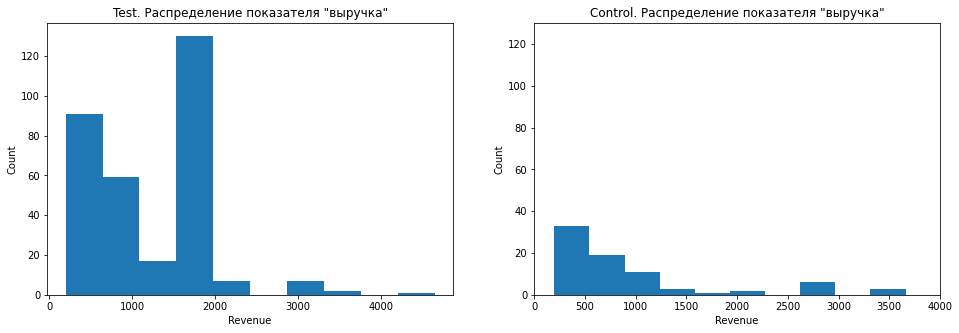

In [42]:
# Установим настройки графика
ax = plt.subplots(1, 2, figsize=(16, 5))

# Построим график распределений тестовой группы
plt.subplot(1, 2, 1)
plt.hist(test.rev)
plt.title('Test. Распределение показателя "выручка"')
plt.xlabel('Revenue')
plt.ylabel('Count')

# Построим график распределений контрольной группы
plt.subplot(1, 2, 2)
plt.hist(control.rev)
plt.title('Control. Распределение показателя "выручка"')
plt.xlabel('Revenue')
plt.ylabel('Count')

# Установим графикам одинаковые оси
plt.xlim(0, 4000)
plt.ylim(0, 130)

plt.show()

График с контролем скошен влево, что в целом нормально для такого признака как выручка. У графика с тестом обнаруживается достаточно ярко выраженный пик с выручкой в 2000. Почему так? На ум приходят два варианта:

1. Ввели какой-то новый продукт с этой стоимостью.
2. Запуск рекламной кампании на уже существующий продукт.

Это только доказывает необходимость проверки системы сплитования. Так как в случае A/B-тестирования в экспериментальную группу должны попасть пользователи, отличающиеся от контрольной только на один фактор.

Text(0, 0.5, 'Count')

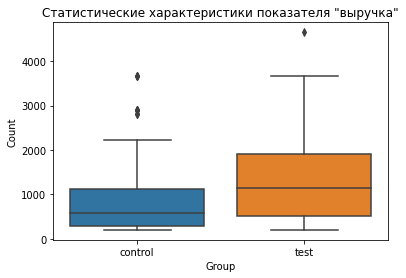

In [43]:
sns.boxplot(x = 'grp', y = 'rev', data=ab_testing.query('rev > 0'))
plt.title('Статистические характеристики показателя "выручка"')
plt.xlabel('Group')
plt.ylabel('Count')

На боксплотах видно несколько выбросов как в контрольной, так и в тестовой группе. В тестовой группе заметно увеличился размах признака (выручки). Заметно, что третий квартиль контрольной группе примерно равен медиане в контрольной.

Проведём тест Шапиро-Уилка на определение нормальности распределения. В связи с небольшой выборкой, сэмплировать наши данные не нужно.
- **H0:** величина распределена нормально.
- **H1:** величина распределена ненормально.

In [44]:
print('Результаты контрольной группы: \t', ss.shapiro(control.rev))
print('Результаты тестовой группы: \t', ss.shapiro(test.rev))

Результаты контрольной группы: 	 ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
Результаты тестовой группы: 	 ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


**P-value намного меньше 0.05, отклоняем нулевую гипотизу и принимаем альтернативную (выручка наспределена ненормально).**

Так как распределение ненормально, определим гомогенность дисперсии с использованием теста Левена:

- **H0:** дисперсии равны.
- **H1:** дисперсии не равны.

In [45]:
ss.levene(control.rev, test.rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

**P-value > 0.05, нулевую гипотезу о равенстве дисперсий принимаем.**

Что мы имеем:
1. Разница в количестве контрольных и тестовых наблюдений более чем в 4 раза;
2. Несколько выбросов в обоих группах, все выбросы в бОльшую сторону;
3. Ненормальное распределение;
4. Однородные дисперсии.

Разница в наблюдениях двух групп негативно сказывается на использовании непараметрического U-теста. Наличие выбросов и ненормальное распределение хоть и не является строгим ограничеием для использование t-теста, все равно может дать погрешность. В данном случае бутстрэп поможет нам нивелировать все нюансы, поэтому будем использовать его.

- **H0:** средний чек в контрольной и тестовой группе не отличаются.
- **H1:** средний чек в контрольной и тестовой группе отличаются.

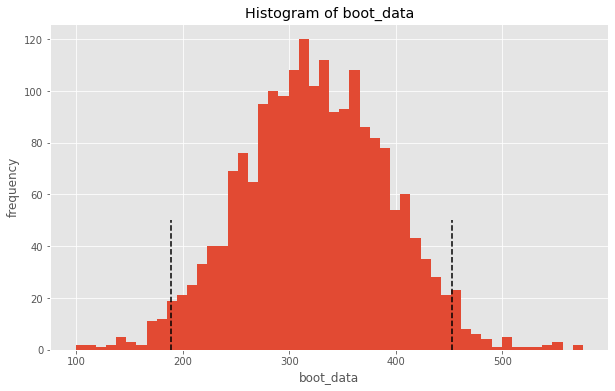

P-value: 	 2.135701172312924e-06


In [46]:
booted_data = get_bootstrap(test.rev, 
                            control.rev,
                            boot_it = 2000)

print('P-value: \t', booted_data['p_value'])

In [47]:
booted_data['ci']

,0
0.025,188.486237
0.975,453.027801


**P-value намного меньше 0.05, поэтому отклоняем нулевую гипотезу и принимаем альтернативную.** Новая механика статистически достоверно увеличила средний чек.

Также мы можем проверить статзначимость изменения конверсии. Так как оба признака категориальные, будем использовать хи-квадрат Пирсона.
- Н0: новая механика оплаты не влияет на конверсию.
- H1: новая механика оплаты влияет на конверсию.

In [48]:
# Создаём колонку "is_purchase", где клиент: 1 - купил, 0 - не купил
ab_testing['is_purchase'] = ab_testing.rev.apply(lambda x:1 if x>0 else 0)

# Создаём таблицу сопряжённости
chi_square = pd.crosstab(ab_testing.grp, ab_testing.is_purchase)
chi_square

is_purchase,0,1
grp,,
control,1460,78
test,6489,314


In [49]:
chi_square, prob, df, expected = ss.chi2_contingency(chi_square)

output = 'test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n'

print(output.format(chi_square, df, prob))

print(expected)

test Statistics: 0.48480826522557896
degrees of freedom: 1
p-value: 0.48625240457231045

[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


**P-value > 0.05, поэтому принимаем нулевую гипотезу.** Новая механика оплаты не оказывает влияния на конверсию в покупку.

### Задание 1. Выводы

#### Техническая часть.
За неимением достаточной информации о новой фиче, а также о планировании и ходе эксперимента, во время выполнения задачи приходилось делать ряд допущений. Всё же следует найти ответы на следующие вопросы:
- Почему в тестовой группе участников больше, чем в контрольной?
- Почему в группу попали пользователи, которые были неактивны, но совершили покупку?
- Почему в распределени выручки в тестовой группе появился пик на 2000?

Ответы на эти вопросы кроются в двух местах:
- Подробности о фиче;
- Проверка системы сплитования. Возможно, она сломана, но за неимением дополнительной информации я это доказать не могу.

#### Продуктовая часть.
Хоть и был сделан ряд допущений, мы все равно можем сделать выводы об эффективности новой фичи:
- Она не оказывает влияния на конверсию в покупку;
- Средний чек статистически достоверно увеличился на 34.6% для активных платящих пользователей.

**Раскатываем новую механику оплаты на всех пользователей.**


### Задание 2. SQL

**Условие.** Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

##### Задача 1

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

*NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

In [50]:
# Подключаемся к default
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [51]:
query1 = '''
SELECT
    COUNT(DISTINCT st_id) AS tough_students
 FROM (
    SELECT 
        st_id
     FROM default.peas
     WHERE
        toStartOfMonth(timest) = '2020-03-01'
     AND
        correct = 1 
     GROUP BY
        st_id
     HAVING 
     COUNT(correct)>=20
    )
'''

query1 = ph.read_clickhouse(query=query1, connection=connection_default)
query1

,tough_students
0,0


Вопрос на самом деле был с подвохом, так как в таблице находятся данные только за два дня:

In [52]:
query2 = '''
SELECT
    DISTINCT(toStartOfDay(timest)) AS Days
 FROM peas
'''

query2 = ph.read_clickhouse(query=query2, connection=connection_default)
query2

,Days
0,2021-10-30
1,2021-10-31


Так что посчитаем количество усердных учеников за эти два дня:

In [53]:
query3 = '''
SELECT
    COUNT(DISTINCT st_id) AS tough_students
 FROM (
    SELECT 
        st_id
     FROM 
         peas
     WHERE
        correct = 1 
     GROUP BY
        st_id
     HAVING 
         COUNT(correct)>=20
    )
'''
query3 = ph.read_clickhouse(query=query3, connection=connection_default)
query3

,tough_students
0,136


**Ответ: 136 учеников были усердны в октябре 2021.**

**Условие.** Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

##### Задача 2

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

*ARPU считается относительно всех пользователей, попавших в группы.*

*Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.*

*Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.*

In [54]:
query4 = '''
SELECT
    test_grp,
    ROUND(SUM(checks.money) / uniqExact(studs.st_id), 2) AS ARPU,
    ROUND(SUM(checks.money) / uniqExact(checks.st_id), 2) AS ARPAU,
    ROUND(uniqExact(checks.st_id) / uniqExact(studs.st_id), 2) AS CR,
    ROUND(uniqIf(checks.st_id, all_activity > 10) / uniqIf(studs.st_id, all_activity > 10), 2) AS active_CR,
    ROUND(uniqIf(checks.st_id, math_activity >= 2) / uniqIf(studs.st_id, math_activity >= 2), 2) AS math_CR
 FROM
    studs
 LEFT JOIN (
    SELECT
        st_id,
        SUMIf(correct, subject = 'Math') as math_activity,
        SUM(correct) as all_activity
     FROM
        peas
     GROUP BY
        st_id
                ) AS activity
        ON 
         studs.st_id = activity.st_id
  LEFT JOIN 
     final_project_check as checks
 ON 
     studs.st_id = checks.st_id
GROUP BY test_grp
'''
query4 = ph.read_clickhouse(query=query4, connection=connection_default)
query4

,test_grp,ARPU,ARPAU,CR,active_CR,math_CR
0,control,4540.98,86562.50,0.05,0.12,0.12
1,pilot,11508.47,102878.79,0.11,0.27,0.17


### Задание 3. Функция в Python
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Пара комментариев к функции. Так как исследовательский анализ данных уже проведён, ряд манипуляций (например, добавление дополнительной колонки `is_active`) я опускаю за ненадобностью и для экономии времени обработки кода. В связи с этим, некоторые функции реализованы немного иначе, чем в задании 1. Типы данных в таблице указаны напрямую для исключения ошибок в их автоматическом определении.

In [55]:
def get_metrics(file):
    
    '''
    Функция подгружает новые данные к уже имеющимся и пересчитывает метрики. 
    В аргументы необходимо вставить путь в формате 'файл.сsv' в кавычках.
    Названия заголовков могут отличаться. В файле необходимо расположение столбцов в том же порядке.
    Типы данных указаны в функции напрямую для исключении ошибок считывания. 
    
    '''
    # Однозначно прописываем типы данных и названия колонок
    types = {'id': str, 'grp': str}
    new_names = ['id', 'grp']

    # Считываем новые и старые данные, задавая типы данных и названия колонок
    groups       = pd.read_csv('Проект_2_groups.csv', 
                               sep=';', 
                               names=new_names, 
                               header=0, 
                               dtype=types)
    groups_add   = pd.read_csv(file, 
                               names=new_names, 
                               header=0, 
                               dtype=types)

    # Считываем данные об активных студентах и о выручке
    active_studs = pd.read_csv('Проект_2_active_studs.csv', 
                               sep=',', 
                               names=['id'], 
                               header=0,
                               dtype={'id': str})
    checks       = pd.read_csv('Проект_2_checks.csv', 
                               sep=';', 
                               names=['id', 'rev'], 
                               header=0,
                               dtype={'id':str,
                                      'rev':float})
    # Соединяем таблицы
    full_data = groups.append(groups_add) \
                      .merge(active_studs, how='right', on='id') \
                      .merge(checks, how='left', on='id')

    # Заполняем появившиеся пропуски в выручке
    full_data['rev'] = full_data['rev'].fillna(0)
    
    # Однозначно переименуем группы для удобства
    full_data.loc[(full_data.grp == 'A'), 'grp'] = 'control'
    full_data.loc[(full_data.grp == 'B'), 'grp'] = 'test'
    
    
    # Считаем количество пользователей в тестовой и контрольной группах
    metrics = full_data.groupby('grp', as_index=False) \
                        .agg(active_users=('id', 'count'))
    
    # Считаем количество пользователей, совершивших покупку 
    purchases = full_data.query('rev > 0') \
                         .groupby('grp', as_index=False) \
                         .agg(purchases=('id', 'count'))
    
    # Считаем общую выручку (total_rev) 
    total_rev = full_data.groupby('grp', as_index=False) \
                         .agg(total_rev=('rev', 'sum')) \
                         .round(2)

    # Добавляем метрики в соответствующий датафрейм
    metrics = metrics.merge(purchases,  on = 'grp').merge(total_rev,  on = 'grp')

    # Считаем CR
    metrics['CR'] = round(metrics.purchases / metrics.active_users, 3)

    # Считаем ARPPU (средний чек)
    metrics['ARPPU'] = round(metrics.total_rev / metrics.purchases, 2)

    # Считаем ARPAU
    metrics['ARPAU'] = round(metrics.CR * metrics.ARPPU, 2)
    
    return metrics

In [56]:
metrics = get_metrics('Проект_2_group_add.csv')
metrics

,grp,active_users,purchases,total_rev,CR,ARPPU,ARPAU
0,control,1538,78,72820.0,0.051,933.59,47.61
1,test,6803,314,394974.0,0.046,1257.88,57.86


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [57]:
def get_pics(df):
    sns.set_style('whitegrid')
    ax = plt.subplots(4, 1, figsize=(10, 6))
    
    plt.subplot (4, 1, 1)
    plt.barh(metrics.grp, metrics.total_rev)
    plt.title('Total Revenue')
    plt.ylabel('Group')
    plt.xlabel('Rub')

    plt.subplot (4, 1, 2)
    plt.barh(metrics.grp, metrics.CR)
    plt.title('Convertion Rate')
    plt.ylabel('Group')
    plt.xlabel('Dole')
    
    plt.subplot (4, 1, 3)
    plt.barh(metrics.grp, metrics.ARPPU)
    plt.title('ARPPU')
    plt.ylabel('Group')
    plt.xlabel('Rub')
    
    plt.subplot (4, 1, 4)
    plt.barh(metrics.grp, metrics.ARPAU)
    plt.title('ARPAU')
    plt.ylabel('Group')
    plt.xlabel('Rub')

    plt.subplots_adjust(wspace=3, hspace=2)

    plt.show()

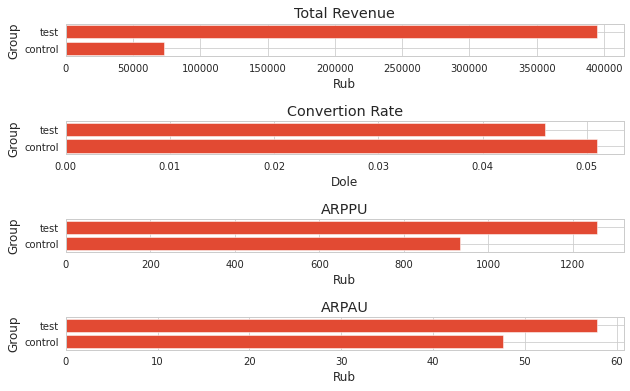

In [58]:
get_pics(metrics)